# 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/.part-00177-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet.crc
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/.part-00062-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet.crc
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/.part-00183-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet.crc
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/part-00107-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/.part-00087-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet.crc
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/part-00151-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/.part-00130-4dd3417b-16db-42f6-8de9-3f12aedebd25-c000.snappy.parquet.crc
/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet/.part-00154-4dd3417b-16db-42f6-8de9-3f12aedebd25-c0

In [2]:
from pyspark.sql.functions import col, hour, date_format, when, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [3]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

# 1) grab the already-running SparkContext (Kaggle has one for you)
sc = SparkContext.getOrCreate()

# 2) wrap it in a SQLContext
sqlCtx = SQLContext(sc)

# 3) point at your folder of part-files
input_path = "/kaggle/input/df-ecom-part-parquet/df_ecom_part_parquet"

# 4) read them all in one go
df = sqlCtx.read.format("parquet").load(input_path)

# 5) sanity checks
print(f"Total records = {df.count()}")
df.printSchema()
df.show(5, truncate=False)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 22:06:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Total records = 26560622
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- user_partition_group: integer (nullable = true)



+-------------------+----------+----------+-------------------+---------------------------------+-------+-----+---------+------------------------------------+--------------------+
|event_time         |event_type|product_id|category_id        |category_code                    |brand  |price|user_id  |user_session                        |user_partition_group|
+-------------------+----------+----------+-------------------+---------------------------------+-------+-----+---------+------------------------------------+--------------------+
|2019-10-02 11:48:09|view      |4501766   |2053013563877884791|appliances.kitchen.hob           |midea  |92.64|513996137|0bb21328-fbba-46fd-8faa-df6c180ed5f2|0                   |
|2019-10-01 16:59:10|view      |6200523   |2053013552293216471|appliances.environment.air_heater|timberk|64.32|515182686|08fab88e-0121-4467-9e4e-b11beac22917|0                   |
|2019-10-02 11:48:15|view      |7900440   |2053013556487520725|furniture.kitchen.chair          |sel

In [4]:
df_ecom_part = df
df_ecom_part.show(5)

+-------------------+----------+----------+-------------------+--------------------+-------+-----+---------+--------------------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|price|  user_id|        user_session|user_partition_group|
+-------------------+----------+----------+-------------------+--------------------+-------+-----+---------+--------------------+--------------------+
|2019-10-02 11:48:09|      view|   4501766|2053013563877884791|appliances.kitche...|  midea|92.64|513996137|0bb21328-fbba-46f...|                   0|
|2019-10-01 16:59:10|      view|   6200523|2053013552293216471|appliances.enviro...|timberk|64.32|515182686|08fab88e-0121-446...|                   0|
|2019-10-02 11:48:15|      view|   7900440|2053013556487520725|furniture.kitchen...|  selby|43.73|555994208|59366a8c-be9e-48e...|                   0|
|2019-10-01 16:59:10|      view|   3800548|2053013566176363511|     appliances.iron|  vitek|28

In [5]:
#  Install PySpark in Colab
!pip install -q pyspark

In [6]:
#  Create SparkSession (after installing)
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("TimeSensitiveRecommender") \
    .getOrCreate()

25/05/05 22:07:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
from pyspark.sql.functions import col, hour, date_format, when, max as spark_max, avg, desc, lit
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.functions import rand

In [8]:
# Extract time features & label (cart/purchase = 1, view = 0)
df_time = df_ecom_part.withColumn("hour", hour("event_time")) \
                      .withColumn("day_of_week", date_format("event_time", "E"))

df_labeled = df_time.withColumn(
    "raw_label",
    when(col("event_type").isin("cart", "purchase"), 1).otherwise(0)
).groupBy(
    "product_id", "category_code", "brand", "hour", "day_of_week"
).agg(
    spark_max("raw_label").alias("label"),
    avg("price").alias("price")
)

In [9]:
#  Split by product_id
unique_products = df_labeled.select("product_id").distinct()
train_products, test_products = unique_products.randomSplit([0.8, 0.2], seed=42)

train_data = df_labeled.join(train_products, "product_id")
test_data  = df_labeled.join(test_products, "product_id")

In [10]:
# Class balance
print("\n🔢 Train Label Distribution:")
train_data.groupBy("label").count().show()

print("🔢 Test Label Distribution:")
test_data.groupBy("label").count().show()


🔢 Train Label Distribution:


25/05/05 22:07:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:07:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:07:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:07:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:07:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----+-------+
|label|  count|
+-----+-------+
|    1| 160347|
|    0|1919396|
+-----+-------+

🔢 Test Label Distribution:


25/05/05 22:08:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----+------+
|label| count|
+-----+------+
|    1| 38612|
|    0|471912|
+-----+------+



In [11]:
# Build and train pipeline
# Undersample negatives to 20% of original
pos = train_data.filter(col("label") == 1)
neg = train_data.filter(col("label") == 0).sample(False, 0.2, seed=42)
train_data_small = pos.union(neg)

# Rebuild indexers (unchanged)
indexers = [
    StringIndexer(inputCol="category_code", outputCol="category_index", handleInvalid="keep"),
    StringIndexer(inputCol="brand",         outputCol="brand_index",    handleInvalid="keep"),
    StringIndexer(inputCol="day_of_week",   outputCol="day_index",      handleInvalid="keep")
]

# Simplify assembler (drop brand_index to reduce cardinality)
assembler = VectorAssembler(
    inputCols=["hour", "day_index", "category_index", "price"],
    outputCol="features"
)

# Configure a smaller, subsampled RandomForest
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=20,         # fewer trees
    maxDepth=5,          # shallower depth
    maxBins=2000,        # support high-card features
    subsamplingRate=0.5  # each tree uses 50% of data
)

# Rebuild and fit pipeline on undersampled data
pipeline = Pipeline(stages=indexers + [assembler, rf])
model = pipeline.fit(train_data_small)

25/05/05 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:09:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:09:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:10:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:10:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:11:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:11:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:11:59 WARN RowBasedKeyValueBatch: Calling spill() on

In [12]:
# Evaluate with F1 and AUC
pred_test = model.transform(test_data)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

print("Test F1-score:", evaluator_f1.evaluate(pred_test))
print("Test ROC AUC:  ", evaluator_auc.evaluate(pred_test))

25/05/05 22:12:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:12:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Test F1-score: 0.9010489894761696


25/05/05 22:13:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/05 22:13:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Test ROC AUC:   0.7161126893620839


In [13]:
# Predict for Specific Time (Saturday 9 PM)
target_hour = 21
target_day  = "Sat"

predict_data = df_labeled.filter(
    (col("hour") == target_hour) & (col("day_of_week") == target_day)
)
predictions = model.transform(predict_data)

# Extract probability of class 1
get_prob = udf(lambda v: float(v[1]), DoubleType())
predictions = predictions.withColumn("prob_class_1", get_prob(col("probability")))

# Show top 10 recommendations
predictions.select("product_id", "category_code", "brand", "price", "prob_class_1") \
           .orderBy(desc("prob_class_1")).show(10, truncate=False)

+----------+----------------------+-------+------------------+------------------+
|product_id|category_code         |brand  |price             |prob_class_1      |
+----------+----------------------+-------+------------------+------------------+
|1005095   |electronics.smartphone|meizu  |133.59            |0.6094042717934255|
|1004024   |electronics.smartphone|xiaomi |131.41199999999998|0.6094042717934255|
|1004777   |electronics.smartphone|xiaomi |135.08535353535353|0.6094042717934255|
|1005100   |electronics.smartphone|samsung|144.64230215827337|0.6094042717934255|
|1004857   |electronics.smartphone|samsung|130.67859649122806|0.6094042717934255|
|1005098   |electronics.smartphone|samsung|145.65777777777774|0.6094042717934255|
|1004564   |electronics.smartphone|meizu  |130.55272727272725|0.6094042717934255|
|1005063   |electronics.smartphone|nubia  |144.6966666666667 |0.6094042717934255|
|1004788   |electronics.smartphone|xiaomi |136.94088235294117|0.6094042717934255|
|1003855   |elec

In [16]:
from pyspark.sql.functions import min as spark_min, max as spark_max, stddev, expr

# 1) Basic summary (count, mean, stddev, min, max)
predictions.select("prob_class_1") \
           .describe() \
           .show()

# 2) Median (approximate)
median = predictions.stat.approxQuantile("prob_class_1", [0.5], 0.001)[0]
print(f"Median = {median}")

# 3) Interquartile Range (IQR)
quantiles = predictions.stat.approxQuantile("prob_class_1", [0.25, 0.75], 0.001)
iqr = quantiles[1] - quantiles[0]
print(f"IQR (Q3−Q1) = {iqr}")

# 4) Range (max − min) and standard deviation
agg = predictions.agg(
    spark_min("prob_class_1").alias("min"),
    spark_max("prob_class_1").alias("max"),
    stddev("prob_class_1").alias("stddev")
).collect()[0]

min_val, max_val, stddev_val = agg["min"], agg["max"], agg["stddev"]
value_range = max_val - min_val

print(f"Min = {min_val}")
print(f"Max = {max_val}")
print(f"Range = {value_range}")
print(f"Std Dev = {stddev_val}")

# 5) Optionally, whole distribution as a histogram (e.g. 10 buckets)
hist = predictions.select("prob_class_1") \
    .rdd.flatMap(lambda row: row) \
    .histogram(10)

print("Histogram bins:", hist[0])
print("Histogram counts:", hist[1])


+-------+-------------------+
|summary|       prob_class_1|
+-------+-------------------+
|  count|               8712|
|   mean| 0.2646361120631004|
| stddev|0.09689797389662103|
|    min| 0.2203101836879556|
|    max| 0.6094042717934255|
+-------+-------------------+



Median = 0.23825915641598297


IQR (Q3−Q1) = 0.017036868377517778


Min = 0.2203101836879556
Max = 0.6094042717934255
Range = 0.38909408810546986
Std Dev = 0.09689797389662103


Histogram bins: [0.2203101836879556, 0.25921959249850257, 0.29812900130904957, 0.33703841011959657, 0.3759478189301435, 0.41485722774069056, 0.4537666365512375, 0.49267604536178444, 0.5315854541723315, 0.5704948629828784, 0.6094042717934255]
Histogram counts: [7761, 24, 61, 25, 64, 159, 0, 0, 2, 616]


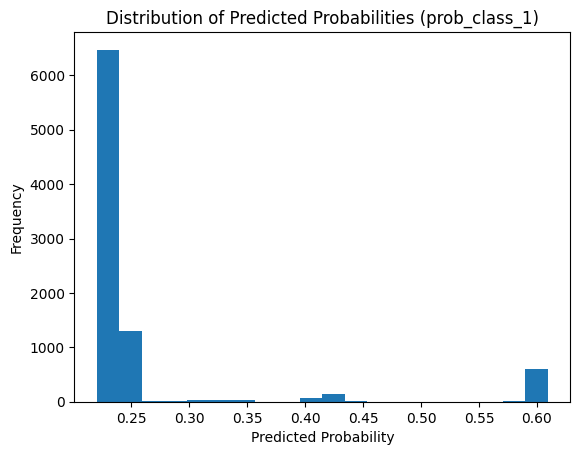

In [17]:
# Collect probability values into Pandas
pdf_probs = predictions.select("prob_class_1").toPandas()

# Plot histogram of prob_class_1 distribution
import matplotlib.pyplot as plt

plt.figure()
plt.hist(pdf_probs['prob_class_1'], bins=20)
plt.title('Distribution of Predicted Probabilities (prob_class_1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


In [18]:
# Filter predictions for high probability products (prob_class_1 > 0.55)
top_preds = predictions.filter(col("prob_class_1") > 0.55)

# Group by category_code and count number of high-probability products
category_counts = top_preds.groupBy("category_code").count().orderBy(col("count").desc())

# Show top categories
category_counts.show(truncate=False)

# Show top products (with their brand and probability)
top_preds.select("product_id", "category_code", "brand", "price", "prob_class_1") \
         .orderBy(col("prob_class_1").desc()) \
         .show(20, truncate=False)

+----------------------+-----+
|category_code         |count|
+----------------------+-----+
|electronics.smartphone|618  |
+----------------------+-----+



+----------+----------------------+-------+------------------+------------------+
|product_id|category_code         |brand  |price             |prob_class_1      |
+----------+----------------------+-------+------------------+------------------+
|1004858   |electronics.smartphone|samsung|131.64670588235293|0.6094042717934255|
|1003907   |electronics.smartphone|huawei |131.27            |0.6094042717934255|
|1005063   |electronics.smartphone|nubia  |144.6966666666667 |0.6094042717934255|
|1004564   |electronics.smartphone|meizu  |130.55272727272725|0.6094042717934255|
|1004788   |electronics.smartphone|xiaomi |136.94088235294117|0.6094042717934255|
|1005098   |electronics.smartphone|samsung|145.65777777777774|0.6094042717934255|
|1004026   |electronics.smartphone|xiaomi |139.3323076923077 |0.6094042717934255|
|1005100   |electronics.smartphone|samsung|144.64230215827337|0.6094042717934255|
|1004887   |electronics.smartphone|oppo   |137.8457142857143 |0.6094042717934255|
|1004777   |elec

In [22]:
# Filter predictions for less probability products 
top_preds = predictions.filter(col("prob_class_1") < 0.30)

# Group by category_code and count number of high-probability products
category_counts = top_preds.groupBy("category_code").count().orderBy(col("count").desc())

# Show top categories
category_counts.show(truncate=False)

# Show top products (with their brand and probability)
top_preds.select("product_id", "category_code", "brand", "price", "prob_class_1") \
         .orderBy(col("prob_class_1").asc()) \
         .show(20, truncate=False)

+--------------------------------+-----+
|category_code                   |count|
+--------------------------------+-----+
|electronics.clocks              |698  |
|apparel.shoes                   |542  |
|computers.notebook              |411  |
|apparel.shoes.keds              |359  |
|electronics.audio.headphone     |321  |
|accessories.bag                 |254  |
|computers.desktop               |229  |
|appliances.kitchen.refrigerators|229  |
|appliances.environment.vacuum   |208  |
|construction.tools.drill        |188  |
|kids.carriage                   |186  |
|electronics.audio.subwoofer     |180  |
|appliances.kitchen.washer       |156  |
|electronics.telephone           |135  |
|auto.accessories.player         |121  |
|sport.bicycle                   |120  |
|electronics.audio.acoustic      |120  |
|computers.peripherals.monitor   |113  |
|electronics.tablet              |110  |
|computers.peripherals.mouse     |95   |
+--------------------------------+-----+
only showing top

+----------+---------------------------------+----------+------------------+------------------+
|product_id|category_code                    |brand     |price             |prob_class_1      |
+----------+---------------------------------+----------+------------------+------------------+
|1480434   |computers.desktop                |smart     |2074.57           |0.2203101836879556|
|3801166   |appliances.iron                  |laurastar |2445.34           |0.2203101836879556|
|6400216   |computers.components.cpu         |intel     |2208.64           |0.2203101836879556|
|21407288  |electronics.clocks               |rado      |2574.07           |0.2203101836879556|
|18500043  |electronics.tablet               |wacom     |1995.11           |0.2203101836879556|
|5100799   |electronics.clocks               |garmin    |1878.5576923076924|0.2203101836879556|
|18900194  |electronics.camera.photo         |sony      |2316.4            |0.2203101836879556|
|21407287  |electronics.clocks          